# There is an error with the input data here which is causing issues with label encoding. Please see the updated version instead!

# Python for Fantasy Football - Understanding Random Forests
Welcome to part 8 of my Python for Fantasy Football series! Since __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__ we have been attempting to create our own expected goals model from the __[StatsBomb NWSL and FA WSL data](https://github.com/statsbomb/open-data)__ using machine learning. I wanted to move away from talking about class imbalance (finally!) to get onto something a bit easier - model interpretation. If you missed any of the previous articles or need a refresher, links are below:

__[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__
, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__, __[Part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__, __[Part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__

When we first looked at machine learning in __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__ we were using sklearn's 'decision tree classifier' to create our models. A single decision tree is easy to understand and implement, making it a good starting point.  However, the main disadvantage of a decision tree classifier is that has a tendency to overfit when you don't set any input parameters. What essentially happens is that the algorithm creates an overly complex tree that fits the training set really well, but doesn't generalise to unseen data.

As we saw in __[part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__, in practice we never really want to use a single decision tree to create models. Why use just one tree when we can use an entire forest?

## Ensemble learners
Ensemble learners work by running multiple models and combining the predictions to obtain better overall results than any individual model could achieve on its own. An example is the 'random forest' algorithm, which trains a 'forest' of weak decision trees and combines the results to create a stronger, more robust model. When you think about it this seems pretty obvious - if you wanted to choose what restaurant to eat at, you would learn more about the quality of the food from the average review score than you would from any individual review. Two common techniques for creating ensemble learners are 'bagging' and 'boosting, which I will run through quickly now.

### Bagging
'Bagging' (short for 'bootstrap aggregating') is a technique where each model in the ensemble votes with equal weight on what the final aggregated model should look like. Random forests are an example of an algorithm that uses bagging techniques. 'Bootstrapping' refers to the process of sampling the data randomly with replacement each time a tree is trained, which means slightly different data-points are used to build each tree. __[This video](https://youtu.be/2Mg8QD0F1dQ)__ does a great job of explaining the concept further.

### Boosting
When using 'bagging', multiple models are run at the same time, the results are averaged, and then the model is tested. 'Boosting' techniques extend this by training each individual model and using the results to inform the next model in the sequence. The process starts with a weak learner, with the results used to inform the next model in the chain (giving it a boost). In one example, samples that are harder to classify are weighted more heavily, so the next model knows to pay more attention to them. After enough iterations you will hopefully arrive at a strong learner that can often perform better than models that just use bagging. __[XGBoost](https://xgboost.readthedocs.io/)__ (eXtreme gradient boosting) is a popular boosting algorithm that often achieves superior results to other methods. __[Here](https://youtu.be/GM3CDQfQ4sw)__ is another short video to explain the concept.

### Stacking
As different types of ensemble learners use different methods to create predictions, they have varying strengths and weaknesses; a bagging algorithm and a boosting algorithm that achieve similar overall results can be comparatively weak in one area and strong in another. In many cases, combining information from multiple unique types of ensemble learners can produce even greater overall performance, by balancing out their individual weaknesses to create a 'super-model'. The downside of stacking is that it adds a lot of complexity, which might not be a good thing in our case as we are at risk of overfitting our small dataset again. Since any potential gains from this approach will likely be marginal I will avoid using it in this series, but it's a technique that might be worth trying out on another dataset.

### Ensemble learners are great!
__[I said last time](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__ that tree ensembles like random forests are pretty much the only machine learning technique you need to know about, so why is that?

-  They work with both categorical and continuous data, and can predict either type using regression or classification. You don't need to do much preprocessing to start training models.
-  They don't make any assumptions about your data, unlike something like logistic regression which assumes a linear relationship.
-  Unlike a single decision tree, it's hard to overfit when using tree ensembles.
-  In practice they tend to achieve results that are at least as good as other techniques (aside from perhaps deep learning).
-  Contrary to popular belief, they aren't a __['black box'](https://en.wikipedia.org/wiki/Black_box)__ technique that's impossible to understand. As we will see in the remainder of this article, we can get a great idea of exactly what's going on with just a few lines of code.

In [235]:
# Reloads modules automatically in case there are any changes
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 2

# Show matplotlib plots without having to call .show()
%matplotlib inline

## Visualising decision trees
Remember the diagram of a decision tree from __[part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__ that I drew in MS Paint? Obviously we can do better than that! Sklearn already has a package built-in so you can visualise decision trees from models you have built, but there is a really nice alternative called __['dtreeviz'](https://explained.ai/decision-tree-viz/index.html)__ which I will be using instead. The only downside is that installation can be a bit fiddly depending on what OS you use, so make sure you __[follow the instructions](https://github.com/parrt/dtreeviz)__ and try the following code if you get any errors:

In [236]:
# First, follow the dtreeviz installation guide to install the latest versions of dtreeviz and graphviz
# https://github.com/parrt/dtreeviz
from dtreeviz.trees import *

# Then run the code below if you get an error telling you that graphviz isn't in your system path (Windows users)
# https://stackoverflow.com/a/44625895
import os
your_graphviz_install_directory = 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.environ["PATH"] += os.pathsep + your_graphviz_install_directory

In [2]:
# Import everything else
import pandas as pd
import numpy as np
from IPython.display import display, Image, display_svg
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from collections import defaultdict

In [3]:
# Load the data from csv to avoid extra preprocessing steps and make it easier to compare models
np_shots = pd.read_csv('np_shots_inc_error.csv')

features = np_shots.drop('goal', axis=1)
labels = np_shots['goal']

# Encode categorical features
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected', 'assisted']

cat_features = features[cat_cols]
cont_features = features.drop(cat_cols, axis=1)

# Use label encoding to convert categorical features to numeric
# https://stackoverflow.com/a/37038257
def label_encode(df):
    # Convert df to label encoded
    df_le = pd.DataFrame({col: df[col].astype('category').cat.codes for col in df}, index=df.index)
    # Save mappings as a dict
    mappings = {col: {n: cat for n, cat in enumerate(df[col].astype('category').cat.categories)} 
     for col in df}
    return df_le, mappings

cat_features_le, mappings = label_encode(cat_features)

# Merge with numeric features
features_le = cont_features.merge(cat_features_le, left_index=True, right_index=True)

# Nice function to view an example of the data with all columns shown (in case you have lots of them!)
# To do this, the columns are transposed into rows instead
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head().transpose())
            
display_all(features_le)

,0,1,2,3,4
distance,36.400549,9.433981,21.954498,13.601471,16.763055
angle,15.945396,57.994617,59.931417,17.102729,17.354025
duration,0.069232,0.914970,2.955827,0.322000,0.515100
play_pattern,8.000000,0.000000,3.000000,8.000000,2.000000
under_pressure,0.000000,0.000000,0.000000,0.000000,0.000000
body_part,0.000000,1.000000,0.000000,0.000000,0.000000
technique,4.000000,4.000000,4.000000,4.000000,4.000000
first_time,0.000000,0.000000,0.000000,0.000000,0.000000
follows_dribble,0.000000,0.000000,0.000000,0.000000,0.000000
redirect,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
for col in ['under_pressure', 'first_time', 'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']:
    summed = cat_features_le[col].sum()
    print(col, summed)

under_pressure 201
first_time 307
follows_dribble 150
redirect 14
one_on_one 177
open_goal 35
deflected 21


In [239]:
# Split off a test set that is representative of our overall dataset using 'stratify'
X_train, X_test, y_train, y_test = train_test_split(features_le, labels, test_size=0.20, 
                                                    shuffle=True, stratify=labels, random_state=42)

# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

2032 total examples in y_train
class 0: 1836 examples, 90.35%
class 1: 196 examples, 9.65%

508 total examples in y_test
class 0: 459 examples, 90.35%
class 1: 49 examples, 9.65%



After running the usual steps to import and preprocess our data, we can start to look at some trees! RandomForestClassifier has a max_depth parameter, which restricts the size of the tree if you specify a value. I will create small trees here with just two levels so we can easily see what's going on.

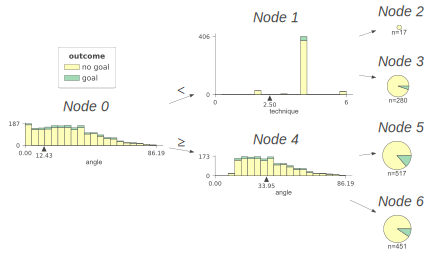

In [224]:
# Train a random forest
# By default the number of trees in the forest is 10, but this is changing to 100 soon, so I have used 100 here
m = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42, n_jobs=-1)
m.fit(X_train, y_train)

# Extract a single tree from the forest to take a look at (tree number 3)
estimator = m.estimators_[3]

# Create our visualisation using dtreeviz
viz = dtreeviz(estimator, X_train, y_train,
               target_name='outcome', 
               feature_names=X_train.columns, 
               class_names=['no goal', 'goal'], # [class 0, class 1]
               orientation='LR', # 'TD' (top-down) by default
               show_node_labels=True)
           
viz

Well it certainly looks better than my MS Paint version, but what exactly is going on here? In this particular tree, 'angle' is the feature at the root (node 0). The model takes the following steps to arrive at the leaf nodes (2-6), where it makes a prediction about whether the outcome was 'goal' or 'no goal':

-  Is the angle of the shot greater than or equal to 12.43 degrees, or less than that?
-  If it's >= 12.43, split up the data again on a different angle (node 4), this time 33.95 degrees.
    -  Make a prediction using the 517 observations from node 5 if the angle is <33.95, otherwise make a prediction at node 6.
-  If it's <12.43, split on technique instead.
    -  If technique is 0, 1 or 2, go to node 2 and make a prediction, otherwise make a prediction at node 3.

There's quite a bit to unpack here, so let's dig in a bit further. We can see that we have no observations for technique of 0 or 1 and angle <12.43, with only a few for technique 2, and none of these observations resulted in a goal either. So what actually are these techniques?

In [220]:
# If you look closely you will see a custom label_encode function above which stores mappings in a dictionary
# It's nice to be able to see which numbers correspond to which values!
print(mappings['technique'])

{0: 'Backheel', 1: 'Diving Header', 2: 'Half Volley', 3: 'Lob', 4: 'Normal', 5: 'Overhead Kick', 6: 'Volley'}


OK, so if it's a half volley from close to the centre of the goal (angle <12.43), this particular tree is predicting 'no goal', whereas if it's 'normal' or 'volley' it's predicting 'goal' with some probability. Does that actually make sense? Well, no, not really. In reality we should pretty much never be predicting zero probability of a goal. Hopefully this illustrates why you don't want to rely on a single decision tree to create a model. It would definitely be nice to have more data here too!

As for the other branch of the tree, it looks like the model will predict goal at a higher frequency for angles under 33.95, which does make sense. However, as we saw in __[part 7](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-part-2/)__ there is a lot of overlap between the two classes, so the model is struggling to make confident predictions for each class. This is still a small tree, but we haven't really got much closer to differentiating between 'goal' and 'no goal' at the leaf nodes.

To illustrate, let's take another look at the breast cancer dataset. I've picked a random observation to look at, showing it's path through the tree to arrive at a prediction about whether the features indicate a 'malignant' or 'benign' tumour.

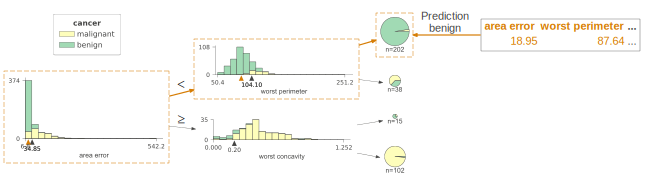

In [229]:
# Set random seed for this notebook cell for reproducible results
np.random.seed(42)

bc = load_breast_cancer()

X_bc = bc.data
y_bc = bc.target

m = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=-1)
m.fit(X_bc, y_bc)

# Extract single tree (tree number 4)
estimator_bc = m.estimators_[4]

# pick random observation to investigate
obs_bc = bc.data[np.random.randint(0, len(bc.data)),:]

viz = dtreeviz(estimator_bc, X_bc, y_bc,
               target_name='cancer', 
               feature_names=bc.feature_names, 
               class_names=['malignant', 'benign'],
               orientation='LR',
               X=obs_bc)
           
viz

Even though we still only have a max tree depth of two, our model is able to predict 'malignant' or 'benign' with high confidence! In this case the random observation we picked had an 'area error' of <34.85 and a 'worst perimeter' of <104.10, so this particular tree is assigning a high probability of a 'benign' tumour. If we increased the tree depth further, we might even be able to predict 'benign' with 100% certainty. Most of the 'malignant' tumours appear to have a large 'area error' and a 'worst concavity' of >0.2, which makes it easy for the model to spot them. If only we had features that good...

Let's take a look at a bigger tree, this time with max_depth=3.

In [233]:
# Set random seed for this notebook cell for reproducible results
np.random.seed(42)

m = RandomForestClassifier(n_estimators=100, max_depth=3, n_jobs=-1)
m.fit(X_train, y_train)

# Extract a single estimator (tree number 6)
estimator = m.estimators_[6]

# Pick a random observation to investigate
obs = X_train.values[np.random.randint(0, len(X_train.values)),:]

viz = dtreeviz(estimator, X_train, y_train,
               target_name='outcome', 
               feature_names=X_train.columns, 
               class_names=['no goal', 'goal'],
               orientation='TD',
               fancy=True, # simplifies the viz (no histogram) if set to False
               X=obs)
           
viz.view() # opens viz in a web browser (useful for bigger trees or small screens)

In this case the tree is splitting on a distance of 15.25 first, with various features used after that. A normal technique shot with distance=28.02 and angle=34.82 results in a 'no goal' prediction. If we want the probability estimate for 'no goal', the model will take the percentage of 'no goal' outcomes from the 601 observations at that leaf node. Unfortunately the limitations of our data are clear to see, but hopefully this gives you a much better idea of what exactly is going on inside the random forest algorithm.

## Random forest hyperparameters
Most machine learning algorithms have different settings, called 'hyperparameters', that you can adjust to change the performance of your model. We've already seen some of them:

-  n_estimators = number of trees in the forest. Typically adding more trees won't decrease model performance, but it will increase the training time significantly.
-  max_depth = maximum depth of the tree. This is set to 'None' by default, which could result in a lot of splits if the tree is struggling to make good predictions.
-  n_jobs = number of processor cores to use. -1 will use all of them in parallel.
-  random_state = the random seed to use. It's useful to set this when comparing models, but you might want to remove it at the end for a final model.

There are lots more hyperparameters, but the extra ones we will focus on are:

-  max_features = the maximum number of features to look at for a particular split. By default the model will use the square root of the total number of features.
-  min_samples_leaf = the minimum number of samples allowed at each leaf node. By default this is set to one, so the tree might carry on splitting to a point where it starts to overfit the data.

In part 10, I'll show you how to tune the hyperparameters for random forests and XGBoost to see if we can find a combination that improves our model. For now, I've created an interactive notebook widget so you can play around with different values of these hyperparameters and see how this affects the split points of a particular tree.

In [176]:
# This should work by default if you have the latest versions of Jupyter notebook/lab
# I had issues getting mine to work in Jupyter lab, as I had an older version
# If you have problems, see:
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension

from ipywidgets import interactive
def plot_tree(tree_num=4, depth=2, min_leaf=1, max_feat='sqrt'):
    m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42,
                               max_depth=depth,
                               min_samples_leaf=min_leaf,
                               max_features=max_feat)
    m.fit(X_train, y_train)
    # Extract single tree
    estimator = m.estimators_[tree_num]
    
    viz = dtreeviz(estimator, X_train, y_train,
                   target_name='outcome', 
                   feature_names=X_train.columns, 
                   class_names=['no goal', 'goal'],
                   orientation='TD')  
    display(viz)
    return estimator

inter=interactive(plot_tree,
                  tree_num=(0, 99),
                  depth=(1, 4),
                  min_leaf=[1, 3, 5, 10, 25],
                  max_feat=[1, 0.5, 'sqrt', 'log2'])

display(inter)

interactive(children=(IntSlider(value=4, description='tree_num', max=99), IntSlider(value=2, description='dept…

## Feature importance
Feature importance is so important that part 9 will cover it in full detail, but I wanted to give you a quick preview here, as it's something you will want to rely on heavily when trying to interpret your models. Note that __[this isn't the same as the model coefficients you might have seen elsewhere!](https://youtu.be/0v93qHDqq_g?t=36m1s)__ Feature importance is built into sklearn (of course), but this is another situation where I'm going to recommend an alternative approach, as the sklearn version __[can give some weird results.](https://explained.ai/rf-importance/index.html)__ We'll be using the __['rfpimp'](https://github.com/parrt/random-forest-importances)__ module, which uses a method called 'permutation importance'. You can read the full details __[here](https://explained.ai/rf-importance/index.html)__, but the basic steps of this technique are as follows:

1. Fit a model and calculate the score.
2. Randomly shuffle the values in a feature column, so they have no meaningful relationship to the target classes we are trying to predict.
3. Recalculate the model score. A worse score means that the column has some useful predictive value, and vice versa. The feature importance is the difference between the baseline score and the new score.
4. Repeat for every feature column.

Let's take a look at the feature importance for our model. We can use the entire dataset and calculate the brier loss scores using cross-validation, before plotting feature importance using rfpimp.

0.08001511811023622


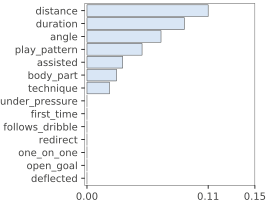

In [4]:
m = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = features_le
y = labels

m.fit(X, y)
scores = cross_val_score(m, X, y, cv=cv, scoring='brier_score_loss')
print(scores.mean()*-1) # Why is this negative by default? See https://stackoverflow.com/a/27364692

from rfpimp import * # pip install rfpimp first
imp = importances(m, X, y, n_samples=-1, metric='brier_score_loss')
viz = plot_importances(imp)
viz

We are getting a brier loss of roughly 0.08, but it looks like half of our input features have no impact whatsoever on model performance! Since events like open goals are rare, it makes sense that the model isn't making use of them. In fact, there aren't even any examples of open goals in our dataset! Let's see what happens when we get rid of those features:

0.0779399212598425


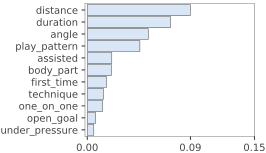

In [23]:
# Get a list of the features where importance is lower than a threshold, and filter them out
def elim_feats(X, imp=imp, thresh=0.005):
    return X[list(imp[imp.values>=thresh].index.values)]

X_new = elim_feats(X=X)

m.fit(X_new, y)
scores = cross_val_score(m, X_new, y, cv=cv, scoring='brier_score_loss')
print(scores.mean()*-1)

imp = importances(m, X_new, y, n_samples=-1, metric='brier_score_loss')
viz = plot_importances(imp)
viz

So we just made our model a lot simpler and our loss improved to 0.0792 as a result?

<p align='left'><img src="https://media.giphy.com/media/11ISwbgCxEzMyY/giphy.gif" /></p>

I'll leave it there for now, but we will definitely be looking at feature engineering more in the next article!

## Conclusion
Thanks for reading! Hopefully you are starting to get a much better understanding of what is actually going on behind the scenes inside random forest models. If you found this article useful, please share it on social media, and keep an eye out for part 9! Thanks to __[StatsBomb](http://statsbomb.com)__ for the data.